# > "Knowledge is of no value unless you put it into practice"

> -- Anton Chekhov

## Motivation

I have read many articles on machine learning, heard everyone else talking about it, but still don't know where to start. Until one day, when I was tunning the accuracy of my Hacker News crawler, it suddenly occurred to me - what I'm doing is to figure out the best parameters of a formula that can tell the possibility of a DOM being the main content, isn't this process called **training** in the terminology of machine learning? isn't it a good idea to feed all those features into a classifier model, and let it do the tunning to find out the best parameters (instead of me doing it manually)?

This is the “aha!” moment for me on machine learning, also the first time to solve a real-world problem using machine learning. So here comes the note I take when falling down the rabbit hole, I'll try to explain things from a newbie's view (actually my view), hoping others may get inspired.


## Problem to Solve

It's super easy to get the main content of a HTML page, if you have done some crawler related works before. 

Let's take a page of `The Times` as an example: [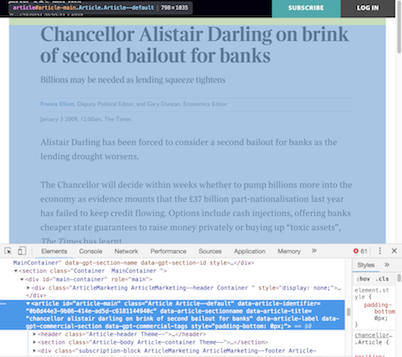](https://www.thetimes.co.uk/article/chancellor-alistair-darling-on-brink-of-second-bailout-for-banks-n9l382mn62h)
You just need to look at where the DOM is in the page using your favorite DOM inspector, write down its `XPATH` or `CSS selector`, then apply the rule to [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) or whatever your library of choices, and you are done - using this rule you can scrap the entire `The Times` and get their main contents, pretty straightforward right?

However, what if you have hundreds of pages to extract content from? writing down their `XPATHes` and using hundreds of `if...else` to apply those rules? Nah, you will become crazy maintaining all those rules. So **extract the main content of "any" page is hard**, how does [Hacker News Digest](http://hackernews.betacat.io/) solve this?

## A Brilliant Way

This method is based on an assumption that the DOM element with the most text is more likely to be the main content. Using this rule only, however, will lead to the `html` DOM been recognized as the main content, because it contains everything, so we also need to take the DOM depth into consideration. Besides, those who have more intensive `<a>` links, look like ADs, comments, sidebars, etc. should be reduced of weight. Combining all those rules, we can score every DOM in a page, and the one with the highest score is the winner to be the main content. Following are the factors currently used to score a DOM:

* The number of words it contains (including descendants)
* The depth it resides in the whole page
* Whether it contains a `h` element that has a high similarity to the title of this page, most blogs will put the title of its article into the `<title>` element for SEO purpose
* Whether its `class` or `id` contains string like `article`, `content`, or `ad-`, `comment`, etc.
* Whether it contains a `<img>`, and the area ratio of that image
* The intensive of its `<a>` links, if all children of an element are the `<a>` links, it's more likely to be a menu or ad, and less likely to be the main content.

After quantifying those factors, I use a linear formula to calculate the score, so the problem becomes - how can I pick the right weight for those factors. The most naive approach is to set them from experience, then test against some pages, and adjust them accordingly. After many trials and errors, I finally found a set of weights that works for most of the pages posted on [Hacker News](https://news.ycombinator.com/), including news websites, blogs, Github readmes, etc.

These weights work so well that my crawler keeps sending me digest of [Hacker News](https://news.ycombinator.com/) posts with high accuracy, but if I want to improve it, or add more rules, I need be careful and add more test cases to stabilize my changes, as it's becoming harder to maintain the balance between the old working weights and a new one. As you may have guessed, this is where **Machine Learning** kicks in!

## A More Sexy Way

Now that I have known the factors contributing to the possibility of a DOM being the main content, why not let the machine learning find the best weights to those factors? as it has a wide variety of models, optimized algorithms to figure out the best weights.

Time to get our hands dirty with some code
![exciting](https://i.giphy.com/media/11sBLVxNs7v6WA/giphy.webp)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

#### Here are the extracted features of a DOM:

In [2]:
dataframe = pd.read_csv('/tmp/features.csv')
dataframe.head()

,target,depth,text_ratio,alink_text_ratio,has_img,contain_title,attr
0,False,0.047619,1.0,0.267532,False,True,"html,story"
1,False,0.095238,1.0,0.267532,False,True,body
2,False,0.142857,1.0,0.267532,False,True,"div,app"
3,False,0.190476,1.0,0.267532,False,True,"div,css,v89234,e1dd99ql0"
4,False,0.238095,1.0,0.267532,False,True,div


* The `target` column means whether this DOM is the main content or not, tagged by me manually.
* The `depth`, `text_ratio` and `alink_text_ratio` columns are three key features I mentioned early, note that they have been normalized so they are comparable across all kinds of web pages. Let me take the `text_ratio` as an example, if DOM A in a page has 500 words, and DOM B in another page has only 100 words, you can not get the conclusion that DOM A has a higher possibility than DOM B to be the main content, because they are from different pages!
* The `attr` column is a set of strings, namely `tag name`, `class` and `id`, as some of them like `article`, `content` are more likely to have a positive contributions, and others like `comment`, `ad` may have negative contributions, which I'll leave to the machine learning algorithm figure out.

In order to convert those `attr` strings into numbers, I'm using the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) method, which tokenizes and counts the word occurrences a text document, so most frequent attributes will have a higher value(count).

#### Now the features become:

In [3]:
y = dataframe.target
X = dataframe.drop(['target'], axis=1)

corpus = X['attr']
vc = CountVectorizer()  
vc.fit(corpus)

numeric_features = pd.concat([X.drop(['attr'], axis=1), pd.DataFrame(vc.transform(corpus).toarray(), columns=vc.vocabulary_)], axis=1)

numeric_features.head()

,depth,text_ratio,alink_text_ratio,has_img,contain_title,blogsearch2_form,postarticle,9b33,clicktalediv,unblock,...,star,70rfte,1k2cjfc,breadcrumb,headerarea,e304,blogs,1e0ws,screencasts_section,directory
0,0.047619,1.0,0.267532,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.095238,1.0,0.267532,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.142857,1.0,0.267532,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.190476,1.0,0.267532,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.238095,1.0,0.267532,False,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



#### I also draw a chart trying to visualize the relationship between `target` and `text_ratio`, `depth`, `alink_text_ratio`, it seems the `text_ratio`(in blue) has the most significant impact on `target`(in red). Whatever, I do not need to worry about their importances any more!


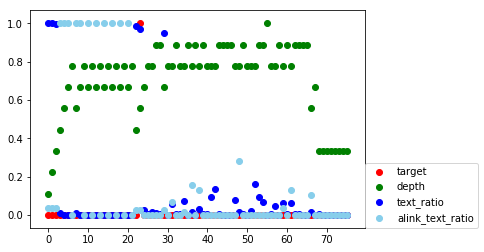

In [5]:
plt.scatter(dataframe.index, dataframe.target, color='red', label='target')
plt.scatter(numeric_features.index, numeric_features.depth, color='green', label='depth')
plt.scatter(numeric_features.index, numeric_features.text_ratio, color='blue', label='text_ratio')
plt.scatter(numeric_features.index, numeric_features.alink_text_ratio, color='skyblue', label='alink_text_ratio')
plt.legend(loc=(1, 0))
plt.show()

#### Next is the `train` and `predict` routine

Here for simplicity reason, I'll just verify against the training dataset itself. But in the real world, you should split your data into training and testing dataset, and use [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) to evaluate the model's performance.

As shown in the code, I also tried several classifiers, the Naive Bayes, Random Forest, and finally chose SVM with a polynomial kernel. I cannot explain why it works better then others, maybe a polynomial model is more suitable in my case.

In [4]:
scaler = preprocessing.StandardScaler()
scaler.fit(numeric_features)
scaled_X = scaler.transform(numeric_features)

# clf = MultinomialNB()
# clf = RandomForestClassifier()
clf = SVC(C=1, kernel='poly', probability=True)
clf.fit(scaled_X, y)
predicted_index = clf.predict(scaled_X).tolist().index(True)

scaled_X = scaler.transform(numeric_features)
pred_y = clf.predict(scaled_X)

print pd.DataFrame(clf.predict_log_proba(scaled_X), 
                                           columns=clf.classes_)

print 'Number of mispredicted out of %d is %d (%.2f%%)' % (y.shape[0], (y!=pred_y).sum(), (y!=pred_y).sum()*100.0/y.shape[0])
print 

print 'Predicted rows:'
print dataframe[pred_y].drop(['text_ratio', 'alink_text_ratio', 'contain_title'], axis=1).merge(pd.DataFrame(clf.predict_log_proba(scaled_X)[pred_y], 
                                           columns=clf.classes_, index=dataframe[pred_y].index), left_index=True, right_index=True)
print 

# print 'Acutual rows:'
# print dataframe[dataframe.target]

        False         True 
0   -0.002231 -6.106299e+00
1   -0.002263 -6.092221e+00
2   -0.002258 -6.094217e+00
3   -0.002263 -6.092019e+00
4   -0.002263 -6.091994e+00
5   -0.002263 -6.091983e+00
6   -0.002263 -6.091982e+00
7   -0.002263 -6.091984e+00
8   -0.002263 -6.091983e+00
9   -0.002263 -6.091982e+00
10  -0.002263 -6.091983e+00
11  -0.002263 -6.091982e+00
12  -0.002263 -6.091983e+00
13  -0.002263 -6.091982e+00
14  -0.002263 -6.091983e+00
15  -0.002263 -6.091982e+00
16  -0.002263 -6.091983e+00
17  -0.002263 -6.091982e+00
18  -0.002263 -6.091983e+00
19  -0.002263 -6.091982e+00
20  -0.002263 -6.091983e+00
21  -0.002263 -6.091982e+00
22  -0.002263 -6.092320e+00
23 -31.137579 -3.008704e-14
24  -0.002261 -6.092956e+00
25  -0.002263 -6.091982e+00
26  -0.002263 -6.091983e+00
27  -0.002263 -6.091983e+00
28  -0.002263 -6.091988e+00
29  -0.002263 -6.092045e+00
..        ...           ...
46  -0.002263 -6.091982e+00
47  -0.002263 -6.091982e+00
48  -0.002263 -6.091982e+00
49  -0.002263 -6.091

## And That’s It 🎉

So we now have a working classifier that can tell us what DOM in a page is most likely to be the main content, and it is just under 20 lines of code! Along the way, I also learnt machine learning is not that obvious, you need to convert your problem into a model-solving one, and that's where machine learning can do the best.

This probably shouldn’t be used in production, because it’s missing loads of features (like evaluating the performance of the model, error handling when the model thinks none of the DOM is the main content etc…) but has hopefully given you a idea that machine learning is not that intimidating, and how it can be used to solve a real-world problem.